# VMTutorial Example

## Tissue stretch 

In this example, we load a configuration of $N=157$ identical hexagonal cells ($A_0 = \frac{3\sqrt{3}}{2}$) placed in an open simulation box. Vertices on the two vertical sides are labelled as ''left'' or ''right''. 

We will use the standard vertex model with energy given as $$E = \frac{1}{2}\sum_c\left[\kappa(A_c - A_0)^2 + \Gamma P_c^2 - \Lambda P_c\right],$$where $\kappa$ is the area modulus, $\Gamma$ is the perimeter modulus, and $\Lambda = 2\Gamma P_0$.

The equation of motion for vertex $i$ is $$\gamma\dot{\mathbf{r}}_i = -\nabla_{\mathbf{r}_i}E + \mathbf{f}_i^\text{pull},$$where $\gamma$ is the friction coefficient between the vertex and the substrate, and $\mathbf{f}_i^\text{pull}$ is the pulling force applied in the horizontal direction only to left and right vertices, with $\mathbf{f}_i^\text{pull,l}=-f^\text{pull}\mathbf{e}_x$ and $\mathbf{f}_i^\text{pull,r}=f^\text{pull}\mathbf{e}_x$.

In [1]:
import trame
import vtk
#print(trame.__version__)

In [2]:
import sys
sys.path.append('/home/ubuntu/Desktop/VMTutorial')

# 确认路径已添加
# print(sys.path)

### Loading the VM simulation module

In [3]:
from VMToolkit.VM import *

### Parameters

Model parameters

In [4]:
kappa = 1.0
Gamma = 0.5
Lambda = 3.0
gamma = 1.0

Simulation parameters

In [16]:
input_file = 'honeycomb.json'
dt = 0.1
rng_seed = 11122023
dumpfreq = 100
nrun = 100
timeunit = int(round(10/dt))
fpull = 0.05

### Simulation initialisation

We now set the simulation object that will constrol the execution.

In [17]:
tissue  = Tissue()                                               # initialise mesh
sim_sys = System(tissue)                                         # base object for the system
forces = Force(sim_sys)                                          # handles all types of forces: is it force compute?
integrators = Integrate(sim_sys, forces, rng_seed)               # handles all integrators
topology = Topology(sim_sys, forces)                             # handles all topology changes (T1, division, ingression)
dumps = Dump(sim_sys, forces)                                    # handles all data output 
simulation = Simulation(sim_sys, integrators, forces, topology)  # simulation object

We proceed to read in the data.

In [18]:
sim_sys.read_input(input_file)

We now plot it to see how it looks like.

/home/ubuntu/.local/lib/python3.8/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/ubuntu/miniconda3/envs/myenv/lib/python3.8/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


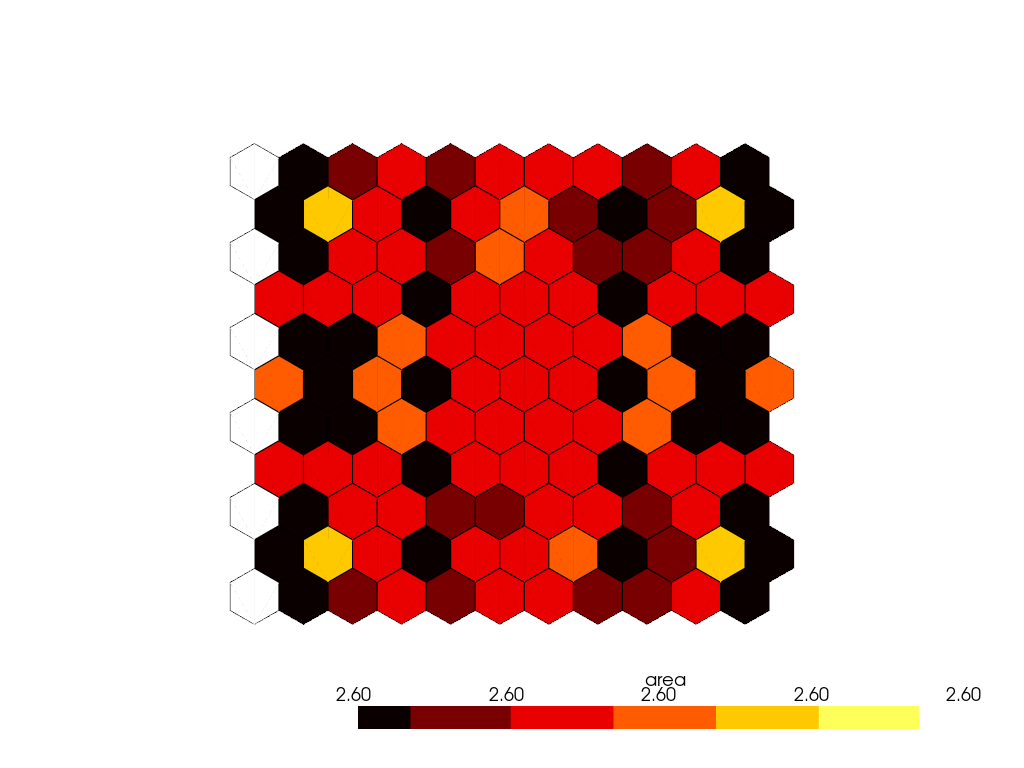

In [19]:
from tissue_plot import make_plotter
make_plotter(tissue).show()

### Add model (force) and assign parameter values

In [20]:
forces.add('area')         # add area force form term E = 0.5*kappa*(A-A0)^2
forces.add('perimeter')    # add perimeter force term from E = 0.5*gamma*P^2 - lambda*P 

Assign parameters to cell type 'passive'

In [21]:
forces.set_params('area', 'passive', {'kappa' : kappa})
forces.set_params('perimeter', 'passive',  {'gamma': Gamma, 'lambda': Lambda})

### Set topology change (i.e. T1 transition) conditions

In [22]:
topology.set_params({'min_edge_len': 0.1, 'new_edge_len': 0.12}) 

### Add integrator for the equations of motion (Brownian dynamics)

In [23]:
integrators.add('brownian') 

Add pulling force:

In [24]:
integrators.set_external_force('brownian', 'right', Vec(fpull,0.0))  # pulling on the right-most column of vertices
integrators.set_external_force('brownian', 'left', Vec(-fpull,0.0))  # pulling on the left-most column of vertices

Set the timestep

In [25]:
integrators.set_dt(dt)

### Exectute simulation

We also produce output as vtp and json files for detailed visualisation and analysis.

In [ ]:
for i in range(nrun):
    if i % dumpfreq == 0:
        dumps.dump_junctions(f'junctions_fpull_{fpull:.4f}_step_{i:08d}.vtp')
        dumps.dump_cells(f'cells_fpull_{fpull:.4f}_step_{i:08d}.vtp')
    simulation.run(timeunit)

### Visualisation post relaxation

We can now take a look into the relaxed configuration

/home/ubuntu/.local/lib/python3.8/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/ubuntu/miniconda3/envs/myenv/lib/python3.8/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


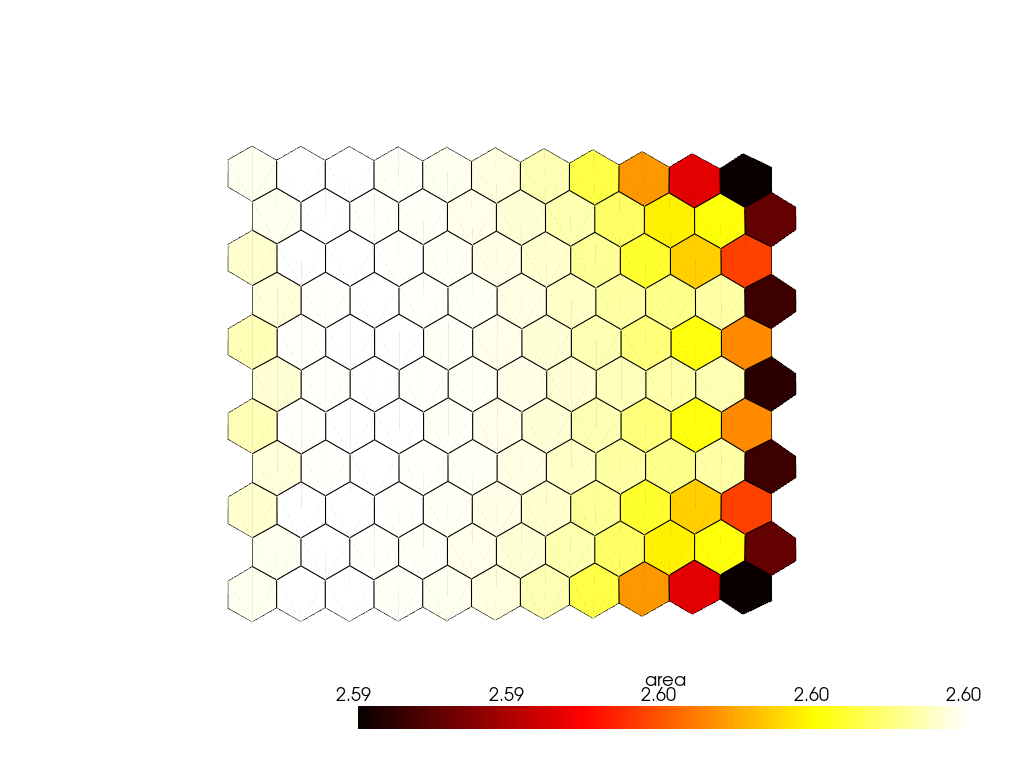

In [17]:
make_plotter(tissue).show()

## Basic analysis

Let's first check the energy.

In [18]:
print(f'Energy per vertex {forces.energy()/len(tissue.vertices())}')

Energy per vertex 1.164581920127588e-06


Then we save the final configuration to 'final.json'

In [44]:
dumps.dump_mesh('final.json')

We now import VMAnalysis module and plot the histogram of cell areas.

In [22]:
from VMToolkit.VMAnalysis import *
import numpy as np
import matplotlib.pyplot as plt

We read in the final configuration from the JSON file.

In [23]:
m = utils.HalfEdge.Mesh()
m.read_json('final.json')

Compute and collect all cell areas.

In [24]:
areas = []
for f in m.faces:
    areas.append(f.area())
areas = np.array(areas)

Plot a histogram

/home/ubuntu/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/ubuntu/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


(array([  0.,   0.,   0.,   0., 157.,   0.,   0.,   0.,   0.]),
 array([2.        , 2.11111111, 2.22222222, 2.33333333, 2.44444444,
        2.55555556, 2.66666667, 2.77777778, 2.88888889, 3.        ]),
 <BarContainer object of 9 artists>)

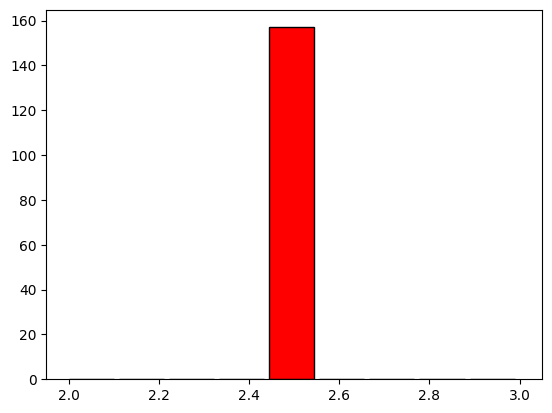

In [25]:
plt.hist(areas, bins=np.linspace(2,3,10),width=0.1,edgecolor='k', facecolor='red')

Calculate texture tensor

In [23]:
M = MTensor('final.json')

Save $\hat{M}$ into a VTK file and visualise it as ellipses.

In [24]:
M.plot_vtk_ellipse('M_ellipses.vtp', scale = 0.25)

Plot the configuration and the M tensor.

In [27]:
import matplotlib.pyplot as plt
import pyvista as pv
cmap = plt.cm.get_cmap("winter", 20)
p = pv.Plotter()
p.add_mesh(pv.read('cells_fpull_0.0500_step_00000600.vtp'), 
        scalars='Area',
        show_edges=True,
        line_width = 1,
        cmap=cmap,
        )
p.add_mesh(pv.read('M_ellipses.vtp'))
p.camera_position = 'xy'
p.show()

/var/folders/m1/0dcyjgv515j5kwn3zj48yl9h0000gq/T/ipykernel_85273/751997107.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("winter", 20)


Widget(value="<iframe src='http://localhost:51514/index.html?ui=P_0x2a71ddb70_6&reconnect=auto' style='width: …